In [1]:
import pickle
import calendar
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import datetime
from dateutil import parser

import warnings

warnings.filterwarnings("ignore")

sns.set(rc={"figure.figsize": (11.7, 8.27)})

In [2]:
files = [f for f in os.listdir('../Data/') if f.endswith('xlsx') and f != '~$December1.xlsx' and f != 'Septemer.xlsx']
dat = pd.DataFrame()
for f in files:
    df = pd.read_excel('../Data/' + f)
    dat = dat.append(df, ignore_index=True)

# dat = pd.read_csv('../Data/data.csv.zip', compression='zip')
# os.chdir('/home/jovyan/git/Direct_Avenue_GRP_Project/')

In [3]:
imp1 = dat[(dat['Impression'].isna()) & (dat['Impression(000)'].isna())]
imp2 = dat[(dat['Impression(000)'].isna()) & (dat['Impression (000)'].isna())]
imp3 = dat[(dat['Impression'].isna()) & (dat['Impression (000)'].isna())]

In [4]:
imp1.drop(['Impression', 'Impression(000)'], axis=1, inplace=True)
imp2.drop(['Impression(000)', 'Impression (000)'], axis=1, inplace=True)
imp3.drop(['Impression', 'Impression (000)'], axis=1, inplace=True)

In [5]:
imp1 = imp1.rename(columns={'Impression (000)': 'Impressions'})
imp2 = imp2.rename(columns={'Impression': 'Impressions'})
imp3 = imp3.rename(columns={'Impression(000)': 'Impressions'})

In [6]:
dat = imp1.append(imp2.append(imp3, ignore_index=True), ignore_index=True)

In [7]:
dat.to_csv('../Data/cleaned_data.csv')

# Feature Engineering Starts Here

In [29]:
dat = pd.read_csv('../Data/cleaned_data.csv').loc[:, "Access":]

In [31]:
uni = pd.read_excel('../Data/station universe.xlsx')
uni = uni.set_index('Station ID')

In [33]:
dat = dat.join(uni, on='Station ID', rsuffix='_uni')

In [41]:
dat['absolute_audience_size'] = dat['GRP'] * dat['subscribers (millions)']

In [42]:
dat['Date Aired'] = pd.to_datetime(dat['Date Aired'], format='%Y-%m-%d')
dat['Time Aired'] = pd.to_datetime(dat['Time Aired'], format='%H:%M:%S').dt.time

In [43]:
def daypart(row):
    if row['Time Aired'].hour >= 0 and row['Time Aired'].hour < 2:
        return('Late Night')
    elif row['Time Aired'].hour >= 2 and row['Time Aired'].hour < 6:
        return('Overnight')
    elif row['Time Aired'].hour >= 6 and row['Time Aired'].hour < 9:
            return('Morning')
    elif row['Time Aired'].hour >= 9 and row['Time Aired'].hour < 16:
        return('Daytime')
    elif row['Time Aired'].hour >= 16 and row['Time Aired'].hour < 19:
        return('Early Fringe')
    elif row['Time Aired'].hour >= 19 and row['Time Aired'].hour < 22:
        return('Primetime')
    else:
        return('Late Fringe')
    
dat['DOW'] = dat['Date Aired'].dt.day_name()
dat['daypart'] = dat.apply(daypart, axis=1)

In [44]:
hours = [x.hour for x in dat['Time Aired'].values]
dat["Hours"] = hours

In [45]:
dat['Date Aired'] = pd.to_datetime(dat['Date Aired'], format='%Y-%m-%d').dt.date
months = [int(x.strftime('%m')) for x in dat['Date Aired'].values]
dat['Month'] = months
bins = [1, 3, 6, 9, 12]
labels = ['Q1', 'Q2', 'Q3', 'Q4']
dat['Quarter'] = pd.cut(dat['Month'], bins, labels=labels)

In [46]:
split_access = dat['Access'].str.split('(^[0-9]{2})|(^[A-Z]{2})')

creative_list = []
for x in split_access:
    if x[1] is None:
        creative_list.append(x[2])
    else:
        creative_list.append(x[3])
        
dat['creative'] = creative_list

In [47]:
outliers = pd.read_pickle('outlier_stations.pickle')
outlier_df = pd.DataFrame(outliers).reset_index()
outlier_df['bins'] = pd.qcut(outlier_df['Station ID'], q=5, labels = [1, 2, 3, 4, 5])
outlier_df.drop(0, axis=1, inplace=True)

outlier_stations = list(outliers.index.get_level_values('Station ID'))[0:12]
dat['is_outlier'] = np.where(np.isin(dat['Station ID'], outlier_stations), 1, 0)
dat = dat.join(outlier_df, on='Station ID', how='left', rsuffix='_')
dat['bins'] = dat['bins'].replace(np.nan, 0)

dat = pd.concat([dat, pd.get_dummies(dat['bins'])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat['creative'])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Estimate"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Market"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["DOW"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat['Quarter'])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["daypart"])], axis=1)

In [48]:
dat = dat.rename(columns={0.0: 'bin_0', 1.0: 'bin_1', 2.0: 'bin_2', 3.0: 'bin_3', 4.0: 'bin_4', 5.0: 'bin_5'})
dat = dat.rename(columns=lambda x: x.strip().replace(' ', '_'))

dat = pd.concat([dat, pd.get_dummies(dat['Hours'])], axis=1)
dat = dat.rename(columns={0: 'midnight', 1: 'one_am', 2: 'two_am', 3: 'three_am', 4: 'four_am', 5: 'five_am',
                          6: 'six_am', 7: 'seven_am', 8: 'eight_am', 9: 'nine_am', 10: 'ten_am', 11: 'eleven_am',
                          12: 'noon', 13: 'one_pm', 14: 'two_pm', 15: 'three_pm', 16: 'four_pm', 17: 'five_pm',
                          18: 'six_pm', 19: 'seven_pm', 20: 'eight_pm', 21: 'nine_pm', 22: 'ten_pm', 23: 'eleven_pm'})
dat.columns

Index(['Access', 'DMA', 'Date_Aired', 'Estimate', 'GRP', 'Impressions',
       'Length', 'Market', 'Media', 'Spot_Cost', 'Spot_Type', 'Station_ID',
       'Time_Aired', 'Station_Category', 'subscribers_(millions)',
       'absolute_audience_size', 'DOW', 'daypart', 'Hours', 'Month', 'Quarter',
       'creative', 'is_outlier', 'Station_ID_', 'bins', 'bin_0', 'bin_1',
       'bin_2', 'bin_3', 'bin_4', 'bin_5', 'BP', 'DC', 'DE', 'DP', 'GD', 'GX',
       'PL', 'PM', 'PN', 'PT', 'SR', 'SV', 'TN', 'VE', 'Q119', 'Q219', 'Q319',
       'Q419', 'Cable', 'DirecTV', 'Dish_Network', 'National_Network',
       'Over-the-top_content', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'Q1', 'Q2', 'Q3', 'Q4', 'Daytime',
       'Early_Fringe', 'Late_Fringe', 'Late_Night', 'Morning', 'Overnight',
       'Primetime', 'midnight', 'one_am', 'two_am', 'three_am', 'four_am',
       'five_am', 'six_am', 'seven_am', 'eight_am', 'nine_am', 'ten_am',
       'eleven_am', 'noon',

In [49]:
def active_flag(row):    
    flag_list = [10, 280, 252, 55]

    if row['Station_ID'] in flag_list and np.isnan(row['Impressions']):
        return(1)
    else:
        return(0)
    
dat['active_flag'] = dat.apply(active_flag, axis=1)

In [50]:
dat.to_csv('../Data/dat_features.csv')

### Load file here

In [2]:
dat = pd.read_csv('../Data/cleaned_data.csv')

.

In [12]:
dat = pd.read_csv('../Data/dat_features.csv')

In [13]:
dat = dat.loc[:, 'Access':'Quarter']

In [67]:
dat.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
GRP,683357.0,0.003117,0.015593,0.0,0.0,0.0,0.0,0.864000
Impressions,683357.0,3.676799,18.363558,0.0,0.0,0.0,0.0,1046.400000
Length,683357.0,29.882916,1.320057,15.0,30.0,30.0,30.0,30.000000
Spot_Cost,683357.0,81.776126,108.334736,0.0,48.0,56.0,96.0,5208.000000
Station_ID,683357.0,199.088294,110.998073,1.0,92.0,219.0,296.0,379.000000
subscribers_(millions),682634.0,29.753520,39.791061,0.4,10.0,24.0,40.0,637.523549
absolute_audience_size,682634.0,0.157112,1.087252,0.0,0.0,0.0,0.0,72.912000
Hours,683357.0,13.901617,5.168686,0.0,10.0,14.0,18.0,23.000000
Month,683357.0,6.888572,3.437203,1.0,4.0,7.0,10.0,12.000000


In [68]:
dat.dtypes

Access                            object
DMA                               object
Date_Aired                datetime64[ns]
Estimate                          object
GRP                              float64
Impressions                      float64
Length                             int64
Market                            object
Media                             object
Spot_Cost                        float64
Spot_Type                         object
Station_ID                         int64
Time_Aired                        object
Station_Category                  object
subscribers_(millions)           float64
absolute_audience_size           float64
DOW                               object
daypart                           object
Hours                              int64
Month                              int64
Quarter                           object
dtype: object

In [10]:
dat["Date_Aired"] = pd.to_datetime(dat["Date_Aired"], format="%Y-%m-%d")
dat["Time_Aired"] = pd.to_datetime(dat["Time_Aired"], format="%H:%M:%S").dt.time

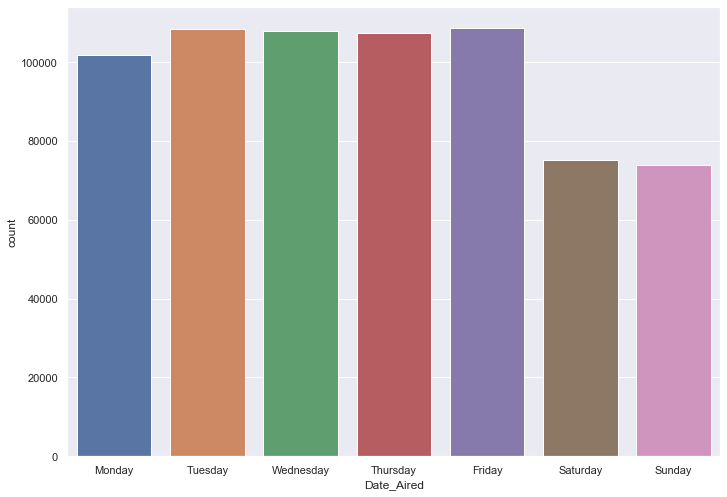

In [11]:
ax = sns.countplot(x=dat["Date_Aired"].dt.day_name(), data=training)

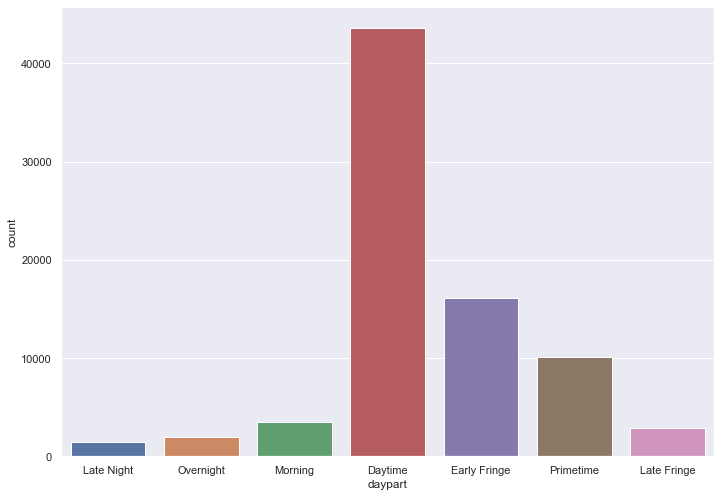

In [12]:
ax = sns.countplot(x=training["daypart"], data=dat)

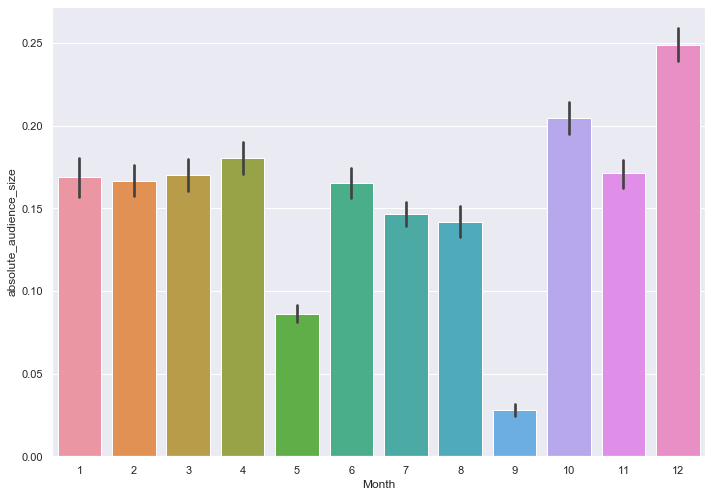

In [19]:
sns.barplot(dat['Month'], dat['absolute_audience_size'])

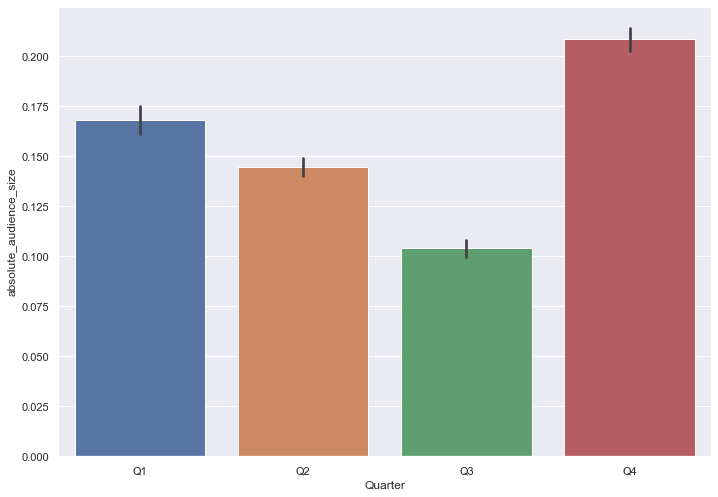

In [17]:
sns.barplot(dat['Quarter'], dat['absolute_audience_size'],
            order=['Q1', 'Q2', 'Q3', 'Q4'])

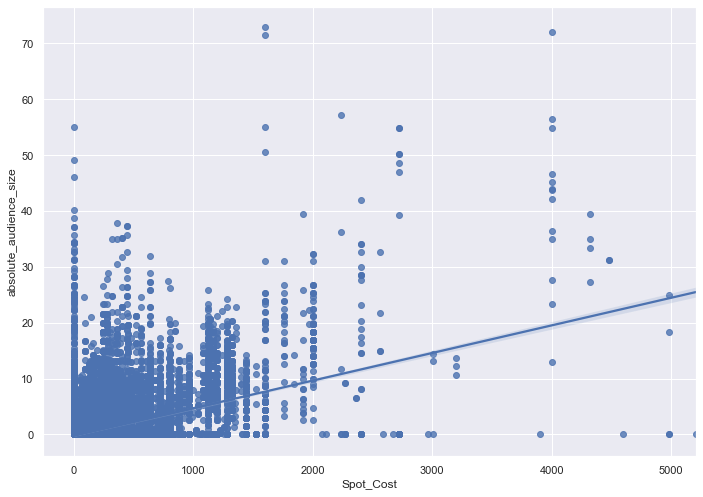

In [13]:
sns.regplot(x=dat["Spot_Cost"], y=dat["absolute_audience_size"])

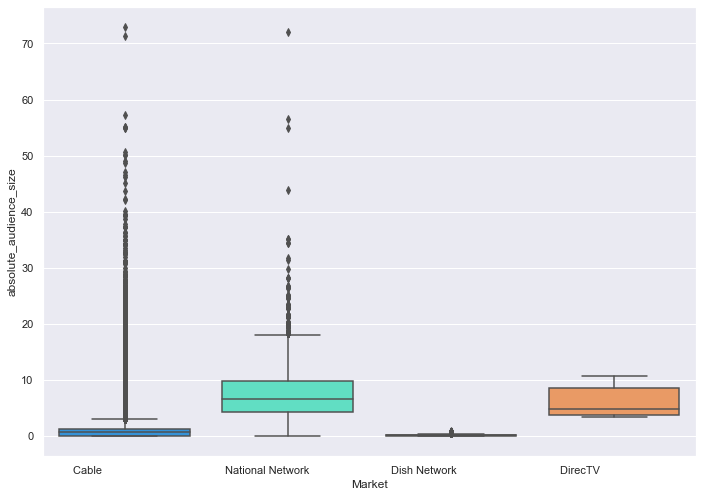

In [20]:
sns.boxplot(x=training["Market"], y=training["absolute_audience_size"], data=training, palette="rainbow")

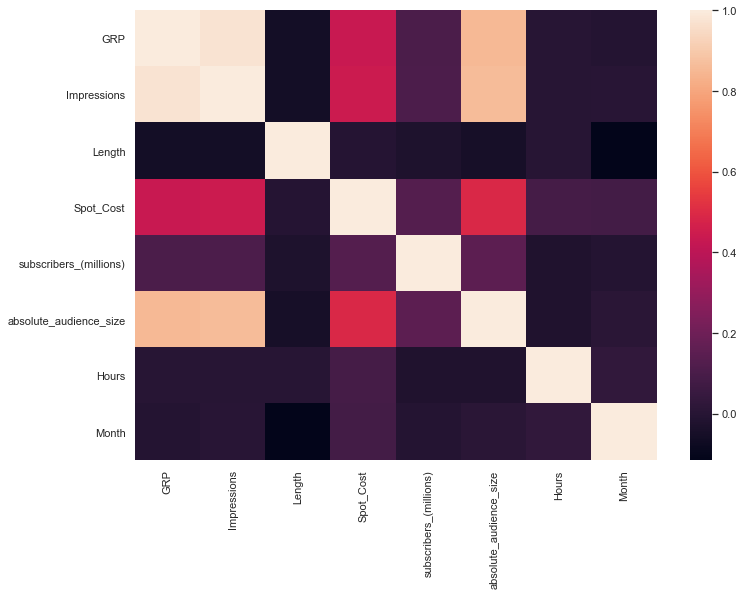

In [14]:
sns.heatmap(dat.drop('Station_ID', axis=1).corr())

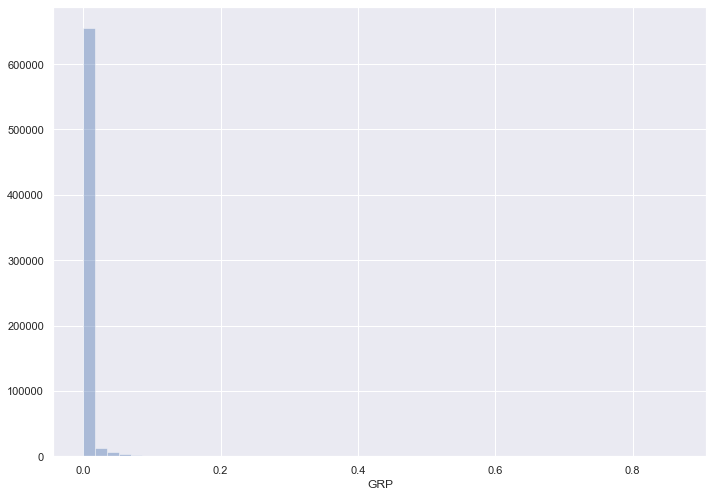

In [8]:
sns.distplot(dat['GRP'], kde=False)

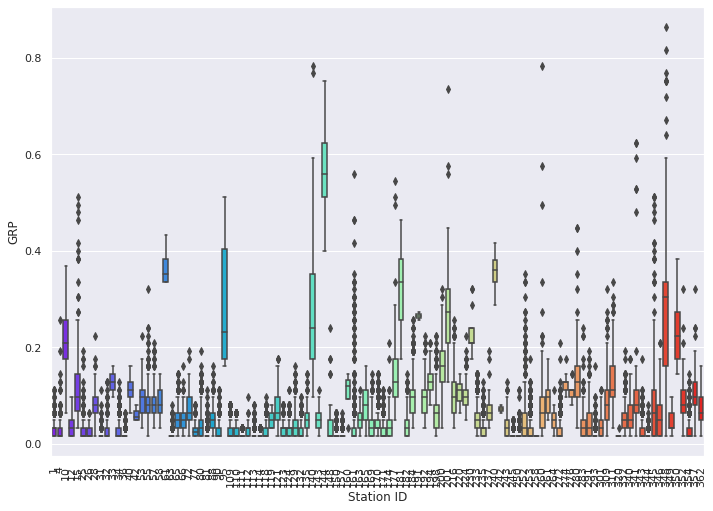

In [23]:
box = sns.boxplot(x=training["Station ID"], y=training["GRP"], data=training, palette="rainbow")
box.set_xticklabels(box.get_xticklabels(), rotation=90)
plt.show()